# Load the data

The data I'm using here, as mentioned, is from the UT Zappos dataset of 50 images.  These images are 136 x 136 x 3.  We need them to be 128 x 128 x 3 for the pix2pix algorithm to work properly.

The load_data function used below (which you can see the entirety of in data_loading.py) takes several steps to prepare the image for use:
- assesses whether there are important pixels in the outer four rows/columns
- crops to 128 x 128 if cropping won't cause loss; otherwise, resizes
- uses the canny edge detector to derive a black-and-white sketch of the pictured object
- assesses the level of detail of the sketch and adjusts if it is outside the desired range

Below is one example of a boot.

Processing image 50067 of 50068
Elapsed time:  15.7 minutes
Image dimension errors:  8
50060 total images processed
(128, 128)


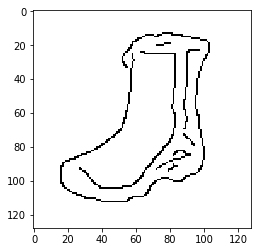

In [1]:
# standard imports
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline

# DL imports
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model, Sequential
import glob
from data_loading import load_data, display_samples

# load data
img_filenames = glob.glob('/floyd/input/ut_zappos50k/**/*.jpg', recursive=True)
img_pairs = load_data(img_filenames, 
                      cap=-1, 
                      min_complexity=450, 
                      max_complexity=750, 
                      verbose=True)

print(img_pairs[0][1].shape)
plt.imshow(img_pairs[0][1], cmap='gray');

Let's see a few image-sketch pairs:

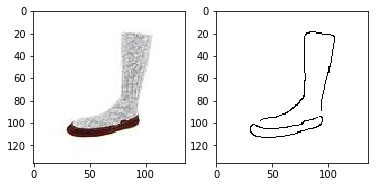

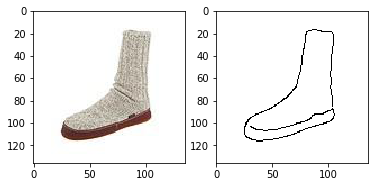

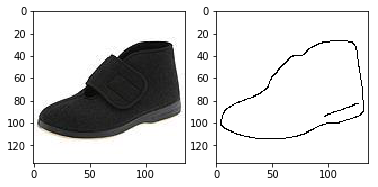

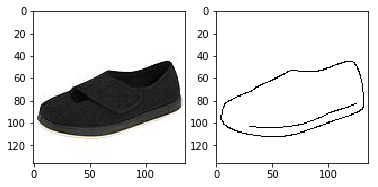

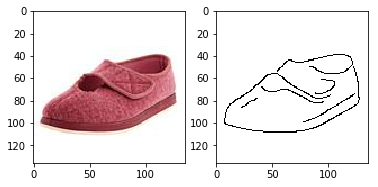

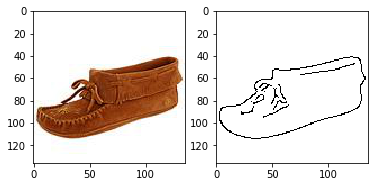

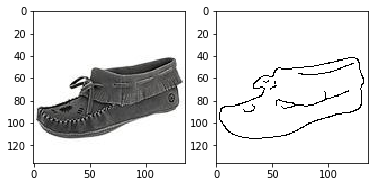

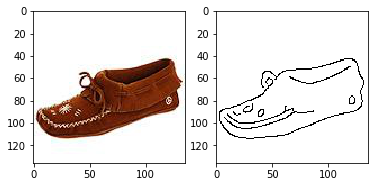

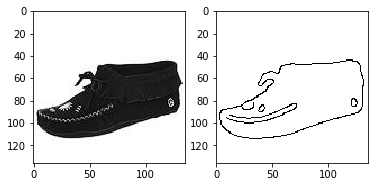

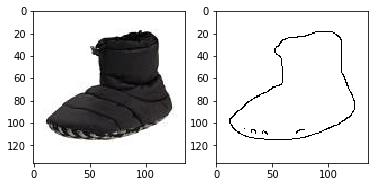

In [16]:
from data_loading import display_transform
for i in range(10):
    display_transform(img_filenames[1275 + i])

And a grid of sketches from a random selection of shoes:

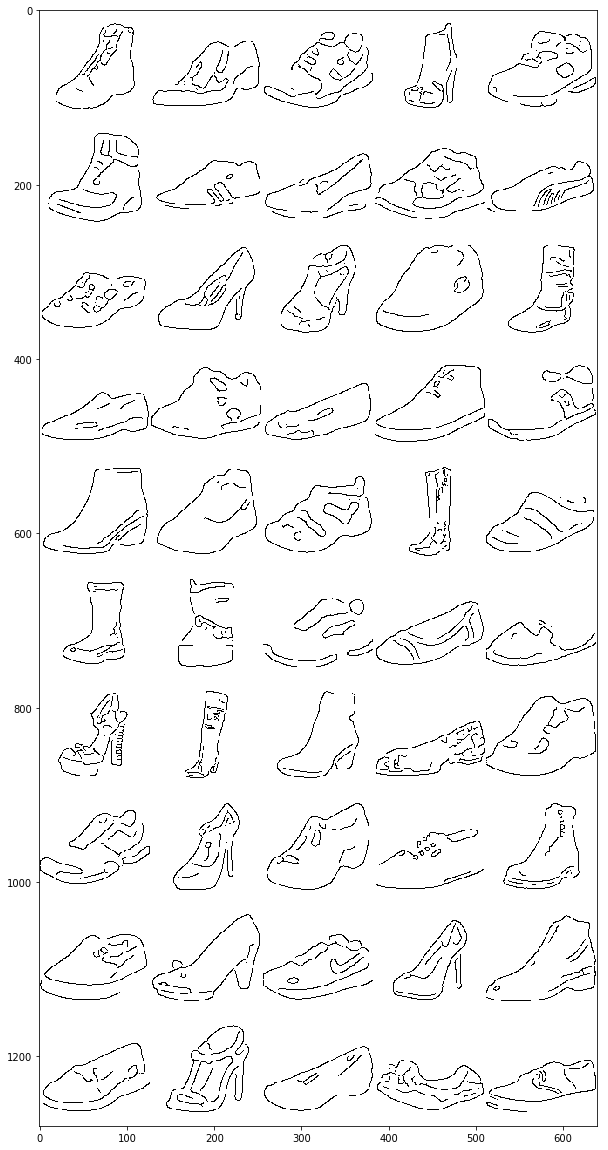

In [11]:
ct = len(img_pairs)
idx = list(range(ct))
np.random.shuffle(idx)
display_samples([img_pairs[i] for i in idx])

These images are fairly small and low-resolution, which will be a major limit on how detailed the images the model produces can be.  There are a wide variety of shoes, ranging from winter boots to stiletto heels.  This may be challenging for the model, but it will allow it to successfully translate a wide variety of designs.

It's also important to note the one critical commonality between all these photographs: they are all taken from the same perspective, with the shoe angled forward and to the left of the frame.  This is probably the biggest constraint of the dataset.  To flesh out designs drawn from other angles would require a significant increase in data and training time.

## Split data for training

Because this is a semi-supervised task with a goal that's ultimately design-oriented, it's more difficult and less critical to maintain a data scientist's habitual rigor around evaluation and confidence intervals.  But it's still important to sequester dev and test sets in order to evaluate the model's performance and see whether it's overfitting the train data and needs further regularization.  A dev set of 2,000 should be plenty - especially given that much of our examination of the results will be manual.  We'll also keep a test set of 1,000 around for final evaluation and metrics.

In [2]:
ct = len(img_pairs)
idx = list(range(ct))
np.random.shuffle(idx)
train_index, dev_index, test_index = idx[:-3000], idx[-3000:-1000], idx[-1000:]

train_img_pairs = [img_pairs[i] for i in train_index]
dev_img_pairs = [img_pairs[i] for i in dev_index]
test_img_pairs = [img_pairs[i] for i in test_index]

# The model

The principle of a generative adversarial network (GAN) is probably familiar to most readers: you design one net to generate (in this example) an image, and another to tell whether a given image is real or not.  They train simultaneously by passing generated images and real-or-not judgments back and forth.  The reason this structure is so effective is that it essentially allows the discriminator net to compute an extremely complex cost function rather than a data scientist trying to hand-code the pixel values that make a shoe look like a real shoe.

The pix2pix model, which my model closely follows, is a cGAN, which means that the generator gets to see a sketch of the image and try to generate that particular shoe.  The discriminator then looks at a pairing of the sketch and the generated image, and at a sketch and the real image, and in each case judges whether the image is real or fake.

## The component models
**The generator model** in this case is a U-net, a type <a href='https://arxiv.org/pdf/1505.04597.pdf'>invented in 2015 by Ronneberger et al</a>.  This model follows a bottleneck structure of convolutional layers that decrease in dimensions (but increase in channels) and then upsample back to the original size.  The U-net design has the unusal feature of having skip-connections between the downsampling and upsampling layers, as in the diagram below from the Freiberg CS department.

![](https://github.com/gqfiddler/sketch2pic/blob/master/u-net-architecture.png?raw=true.png)

**The discriminator model** is a PatchGAN design that essentially looks at each 16x16 "patch" in the image to evaluate its likelihood of being a real photograph.  It uses a series of valid convolutional layers to perform the necessary size reductions.

## The real trick: connecting the components
The tricky part about setting up a cGAN is figuring out how to train the two models.  Each needs the output of the other to train.  And each is trying to push the same loss function in the opposite direction (though the generator also has a mean absolute error loss term to account for basic high-level structure mimicry).  Unfortunately, because (from the generator's perspective) the discriminatory is multiplying the cost by negative one, you can't backpropagate directly through the combined network.  If you do, you will move the discriminator weights in the wrong direction, and its accuracy will get worse and worse.

The solution that most implementations that I've seen use is to train the discriminator separately from the combined cGAN.  This typically means that you have to run your model twice for each training iteration.

I was able to circumvent this by taking advantage of the fact that the discriminator weights get moved in *precisely* the wrong direction by backpropagating through the entire cGAN.  Specifically, if you save the discriminator weights before backpropagating, you can reconstruct the gradients by simply taking the difference between the two sets of weights.  You can then manually assign the corrected values to the manual - keras has a function, set_weights(), that performs this very conveniently.  While this is still a fairly expensive operation due to the hundreds of thousands of weights in the model, it is cheaper than running the model twice.  In my tests, my weight-setting model (cGAN_functions.py) accomplished the same training as the conventional double-running model (cGAN_functions_original.py) in about 75-80% of the time.

The other advantage of this method is that it ensures that the discriminator and the generator are training on the exact same examples.  Because of the numerous 50% dropout layers in the generator, running the generator twice will not result in the same exact image both times.


## Evaluation

This brings us to the tricky subject of evaluation. Evaluating a semi-supervised generative model like this is, as our friends Isola &co put it, "an open and difficult problem."  In their paper, they use Amazon Mechanical Turk to compare model performance to human performance (i.e., can the generated images pass as real images to human viewers).  For a second metric, they evaluated how frequently a FCN-8 network could recognize the generated image as the object it was meant to represent.

These are commendable attempts at an objective metric, but they are both rather beyond the scope of this project's budget, both financially and temporally.  Instead, I'll look at two metrics here.  The first is simply to print out and look at the images.  This isn't objective, but given that we're going for design competence, it's actually a much better proxy for our end goal than showing the images to an FCN-8 net.  

The second metric I'll use is looking at generator loss and discriminator accuracy over time, for both train and dev sets.  If our model is performing as anticipated, we should see low early generator performance with large fluctuations for both models, with a gradual equilibrium emerging in later epochs.  Tracking the dev set metrics separately will allow us to detect any overfitting that occurs.

These are hardly comprehensive or objective measures, but they'll give us a fairly good idea of how our model is performing.

## Early attempts

It's worth noting that large nets like this, especially non-linear ones, there are very many things that can go wrong.  Early versions of this model struggled significantly, starting with a rapid convergence to total failure:

(The top row is the sketches; the bottom row is the target images.  In between are *supposed* to be the generated images)

![Test run 1](https://github.com/gqfiddler/sketch2pic/blob/master/first_trial.png?raw=true.png)

and progressing through a sort of impressionist / cave-art movement...
![Test run 3](https://github.com/gqfiddler/sketch2pic/blob/master/third_trial.png.png)

as well as a promising beginning that literally faded before my eyes:
![Test run 2](https://github.com/gqfiddler/sketch2pic/blob/master/second_trial.png?raw=true.png)

## Problems and solutions

These models struggled for a variety of reasons.  In the end, the key adjustments were:
- re-centering the pixel values around 0 to the range (-1,1) rather than (0,1), or alternatively, switching the generator output activation to a sigmoid.
- decreasing the learning rate and the momentum term (Beta1) used in the Adam optimizer

Neither of these were discussed in the original paper, but they are actually critical for getting usable results.

# Results

I trained the sketch2pic model on 47K images in batches of 4, for 15 epochs.  This training run took four hours and two minutes on a cloud-based Tesla V100 GPU.

In [17]:
from cGAN_functions import sketch2pic
cGAN_1 = sketch2pic(name='seabiscuit', generator_activation='tanh')
cGAN_1.train(train_img_pairs, dev_img_pairs, batch_size=4, epochs=15)

cGAN_1.history.plot_examples(save=True)
cGAN_1.history.save_metrics()
cGAN_1.save_weights()

compiled discriminators
compiled generator


## Images
First, let's take a look at some of the images produced by this training run.  Again, the top run here represents the sketches, the bottom row the real images, and the rows in between the generated images, starting with the first epoch and moving downward toward the last.

![](https://github.com/gqfiddler/sketch2pic/blob/master/full_run_images.jpg?raw=true.png)

There are some odd things going on in the first few rows, but by about halfway through (epoch 8 or so) they really stabilize.  From then on out it's only minor refinement.  The final products still aren't quite as sharp as the real photos (more on that later), but they're quite accurate and realistic.

Now let's see if our learning curves support this picture of things.

In [19]:
cGAN_1.load_weights('seabiscuit')

In [26]:
metrics_df = cGAN_1.history.return_metrics()
metrics_df.head()

,checkpoint,cGAN train_loss,cGAN dev_loss,disc_mean_train_acc,disc_mean_dev_acc,disc_train_acc_real,disc_train_acc_fake,disc_dev_acc_real,disc_dev_acc_fake
0,0.00,98.570000,101.240000,0.50,0.50,1.0,0.00,1.0,0.0
1,0.25,20.720000,23.350000,0.50,0.50,1.0,0.00,1.0,0.0
2,0.50,-inf,-inf,0.50,0.50,1.0,0.00,1.0,0.0
3,0.75,11.160000,15.060000,0.50,0.50,1.0,0.00,1.0,0.0
4,1.00,18.290000,21.820000,0.38,0.45,0.4,0.35,0.6,0.3


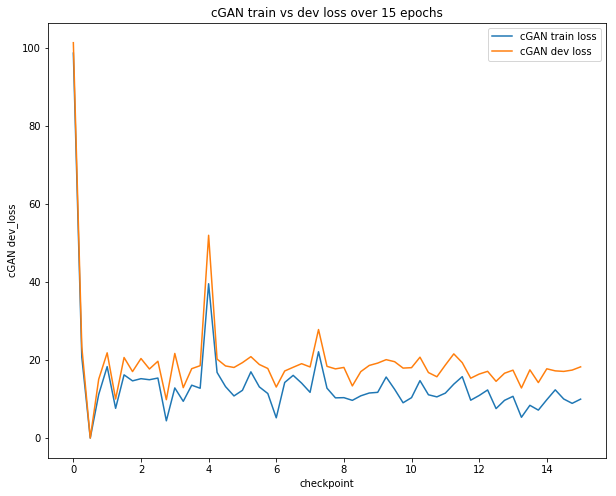

In [43]:
# throw out the odd -inf values
metrics_df.clip(0, 120, inplace=True)

plt.figure(figsize=(10,8))
sns.lineplot('checkpoint', 'cGAN train_loss', data=metrics_df, label='cGAN train loss')
sns.lineplot('checkpoint', 'cGAN dev_loss', data=metrics_df, label='cGAN dev loss')
plt.title('cGAN train vs dev loss over 15 epochs')
plt.legend()
plt.show()

This fits the narrative of the photographs perfectly: loss begins very high and then very erratic (we can even see the big spike in epoch 4, where the yellow smudges appear in the images above).  It then decreases and stabilizes as the generator improves and the generator and discriminator reach equilibrium.

There is some noticeable overfitting going on here.  It's still fairly slight, but it suggests that we may want either a little more data or a little more regularization.  (There's heavy dropout as is, but a slight l2 term could be added.)

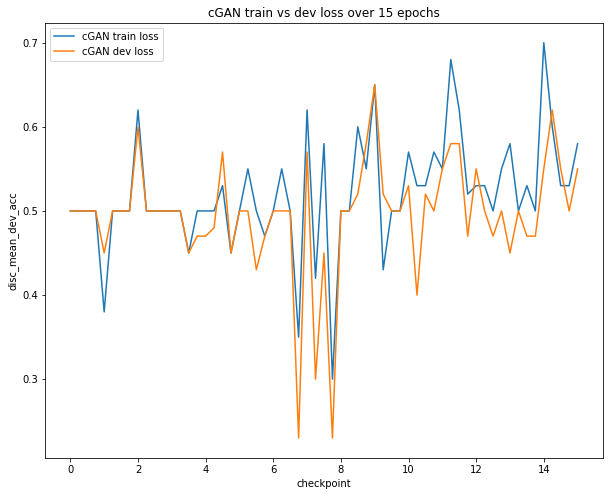

In [44]:
plt.figure(figsize=(10,8))
sns.lineplot('checkpoint', 'disc_mean_train_acc', data=metrics_df, label='cGAN train loss')
sns.lineplot('checkpoint', 'disc_mean_dev_acc', data=metrics_df, label='cGAN dev loss')
plt.title('Discriminator train vs dev accuracy over 15 epochs')
plt.legend()
plt.show()

This chart isn't quite as expected.  The overall trend is still pretty intuitive, with an overall slight increase in accuracy and a fairly high erraticness as the generator improves and the discriminator has to learn new tells to look for.  However, the degree of variance here, even with 20-sample averages, is surprising.  This may indicate that the discriminator needs a smaller learning rate or just larger sampling.  It's also possible that something is a little off with how the metric is being reported from the model.

Since we noticed some overfitting in the generator learnign curve, we can also try taking a look at generated images from the train vs dev vs test sets.

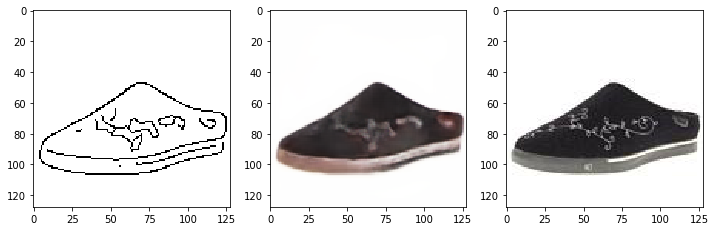

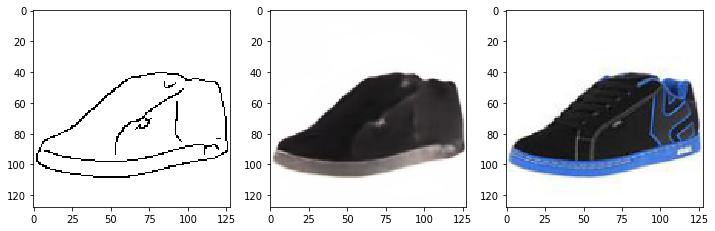

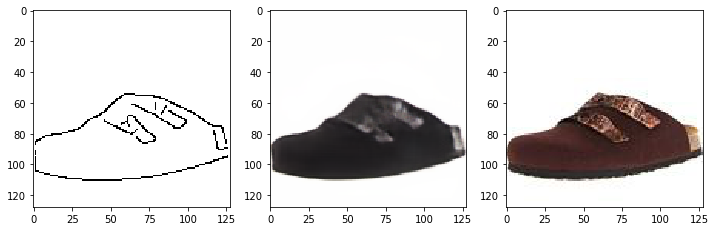

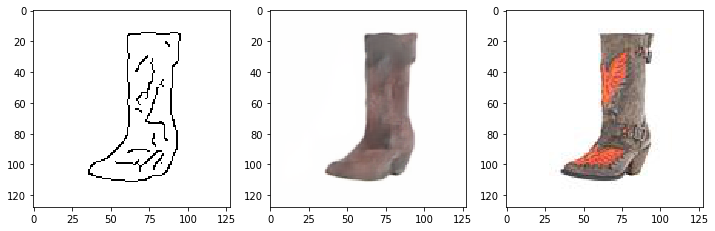

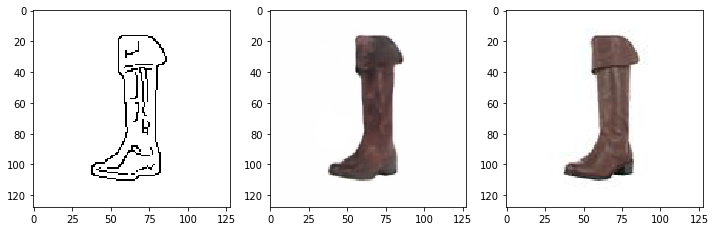

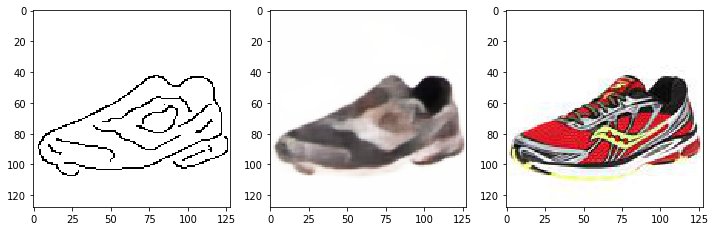

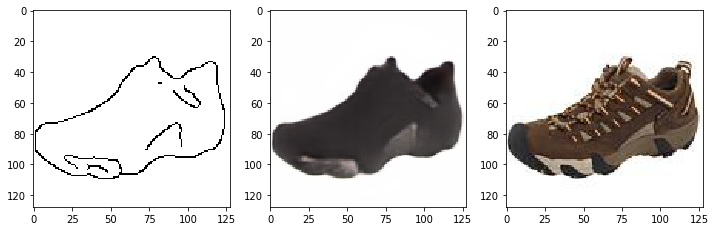

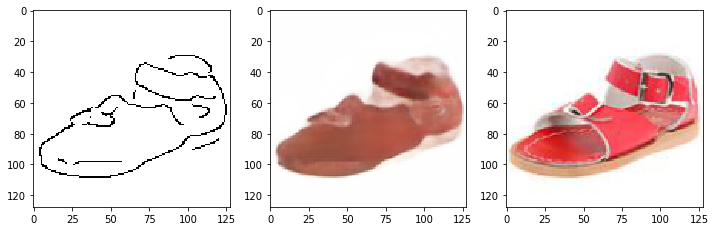

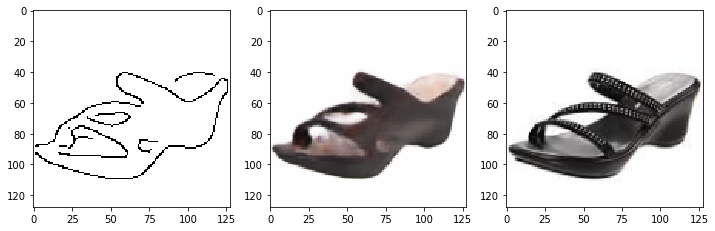

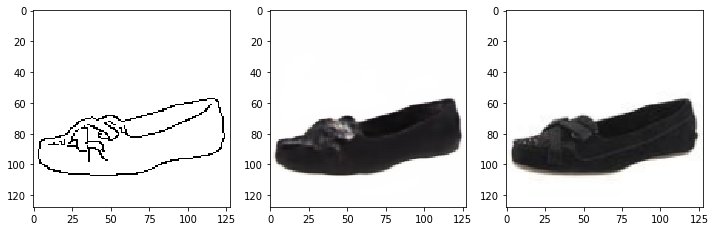

In [28]:
# train set
for i in range(10):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(train_img_pairs[i][1], cmap='gray')
    plt.subplot(132)
    new = cGAN_1.image_from_sketch(train_img_pairs[i][1])
    plt.imshow(new)
    plt.subplot(133)
    plt.imshow(train_img_pairs[i][0])
    plt.show()

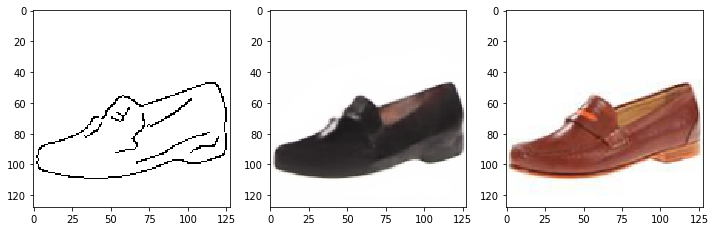

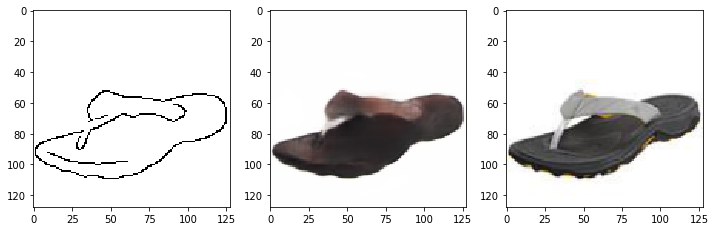

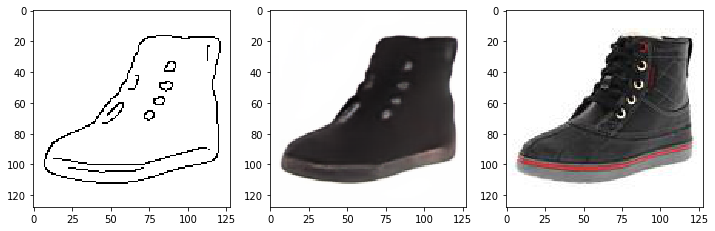

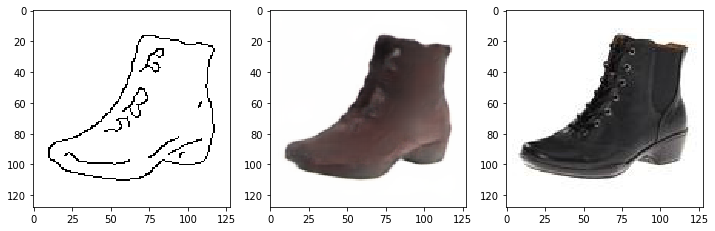

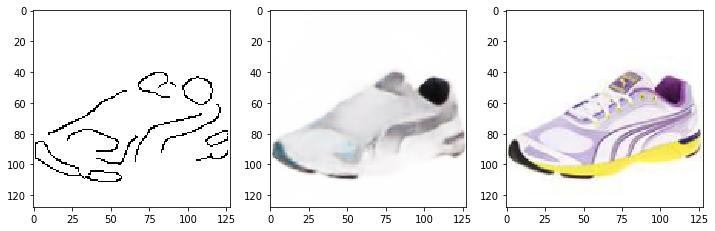

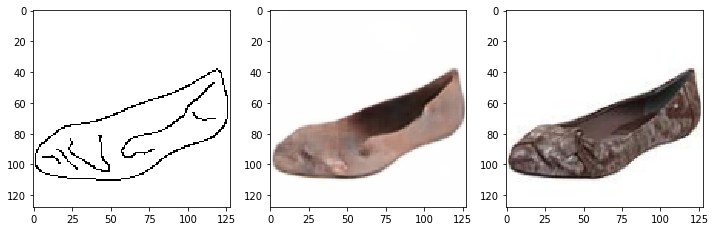

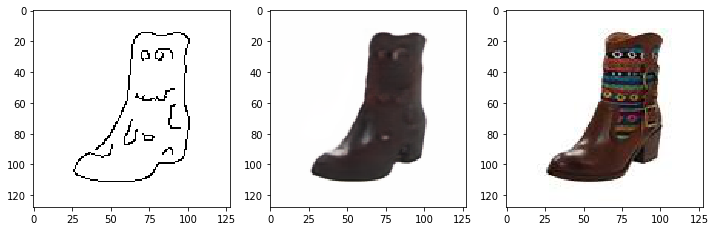

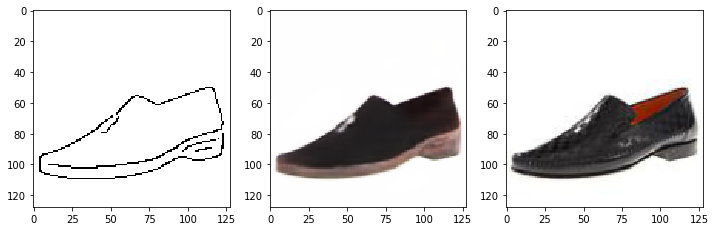

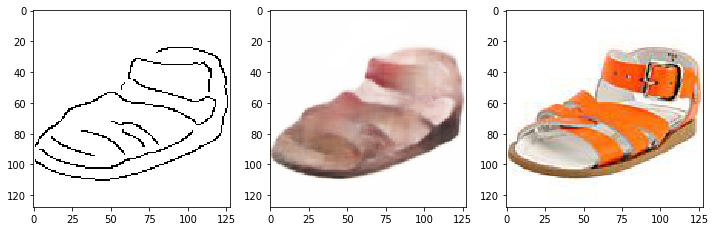

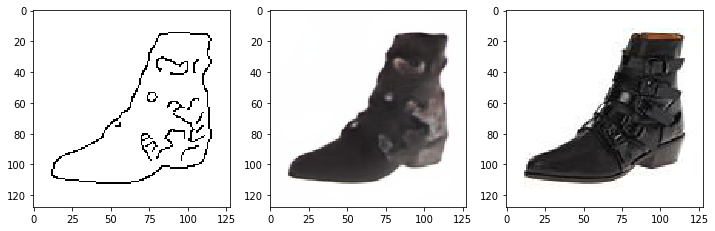

In [29]:
# dev set
for i in range(10):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(dev_img_pairs[i][1], cmap='gray')
    plt.subplot(132)
    new = cGAN_1.image_from_sketch(dev_img_pairs[i][1])
    plt.imshow(new)
    plt.subplot(133)
    plt.imshow(dev_img_pairs[i][0])
    plt.show()

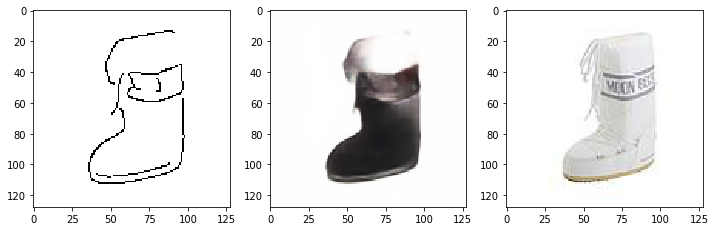

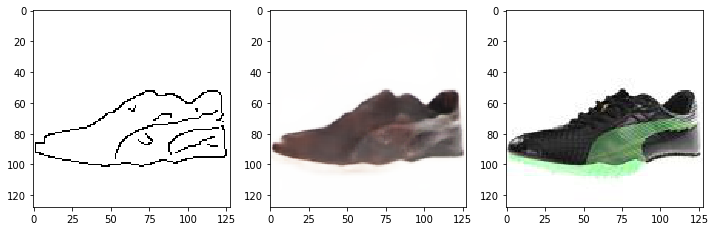

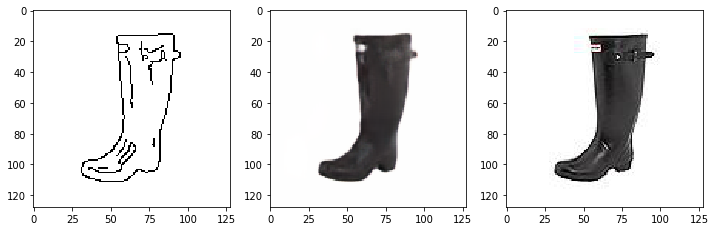

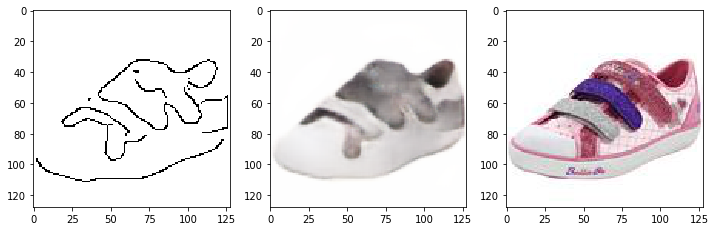

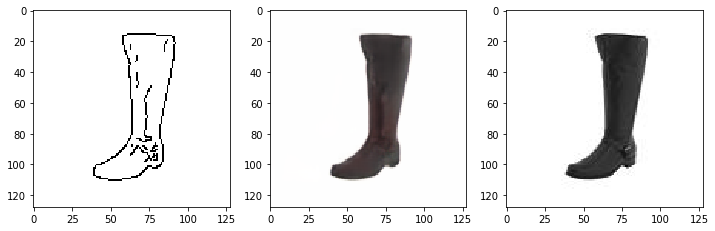

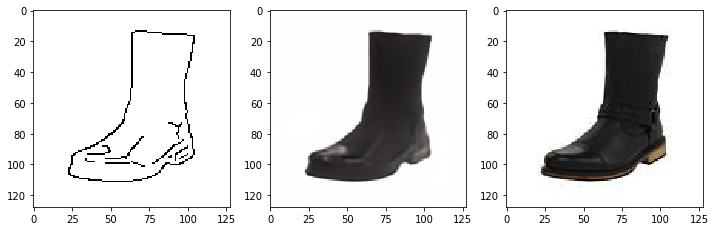

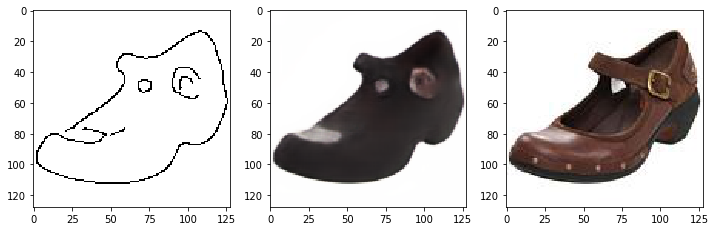

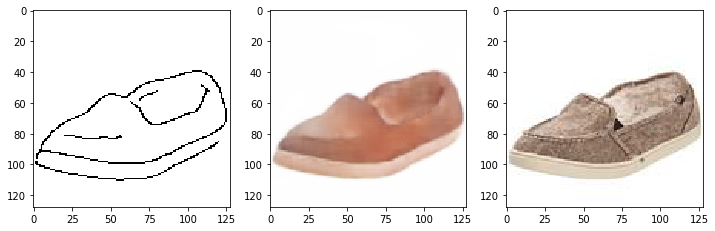

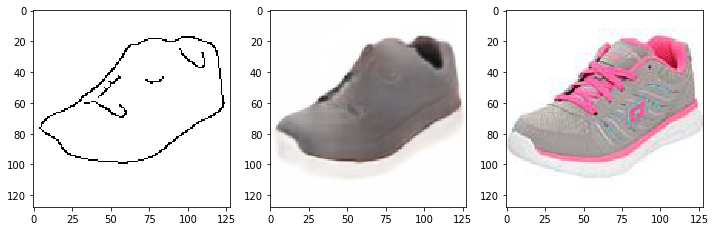

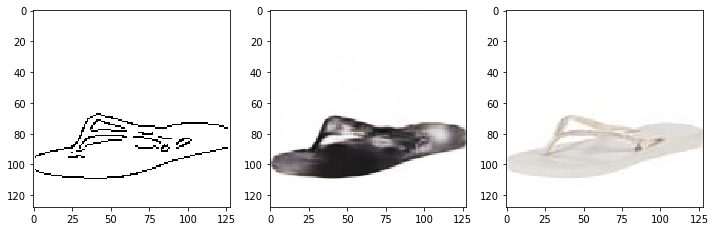

In [30]:
# test set
for i in range(10):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(test_img_pairs[i][1], cmap='gray')
    plt.subplot(132)
    new = cGAN_1.image_from_sketch(test_img_pairs[i][1])
    plt.imshow(new)
    plt.subplot(133)
    plt.imshow(test_img_pairs[i][0])
    plt.show()

My eye can't see a great deal of difference between these results, other than perhaps greater color discrepancies in the test set.

# Conclusions and further improvements

Overall, this is a successful use of a quite complicated model architecture to produce a useful and easy-to-use tool.  A production version of this would need some improved packaging and resolution, but this is a solid working concept of what could be a very useful design tool. 

That said, there are several tuning improvements that could be made.
1. These images are a little blurrier than the originals (albeit both are fairly pixellated because of the small size).  Reducing the lambda_ term that weights the mean squared error may help bring out more texture and give less penalty for 'guessing' wrong about something like color.
2. As mentioned above, a slight increas in regularization in the generator may help with the overfitting.
3. The discriminator looks like it needs a lowered learning rate.  This would be easy to implement in my set_weight() model by adding a multiplicative weight to the gradient before setting the weights.

Finally, I am currently in the final stages of debugging a version that ouptputs five different images for each input sketch.  This would be far more useful for most design purposes.  Just as importantly, it includes a cost function that only penalizes the best generated image of the five (with certain constraints), which incentivizes a high-specificity guessing model.  While there are still one or two small bugs to work out, I think this model is very promising.

While there's always more work that can be done, this model is performing well as is, and serves as a solid proof of concept for a valuable and monetizable industry tool.